In [1]:
import simi

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sentence_transformers import evaluation, losses, models, InputExample, SentenceTransformer, util as stu
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import torch
from tqdm.auto import tqdm, trange
tqdm.pandas()

RANDOM_STATE = 1

random.seed(RANDOM_STATE)

2023-12-18 17:14:36.372136: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
%%time
df = pd.read_pickle("arxiv-full-text-embeddings-single-class-multi.pkl")
print(len(df))
df.sample(5)

272292
CPU times: user 17.8 s, sys: 9.97 s, total: 27.8 s
Wall time: 27.8 s


,text,categories,embedding (Bert+MP),embedding (Bert+MP+class-arx),embedding (Bert+MP+class-zbm),embedding (Mathbert+CLS),embedding (Mathbert+MP+class-arx),embedding (Mathbert+MP+class-zbm),embedding (Bert+TSDAE+MP),embedding (Bert+TSDAE+MP+class-arx),...,embedding (SBert+ret_class-arx),embedding (SBert+ret_class-zbm),embedding (Specter 2+MP),embedding (Specter 2.0+MP+class-arx),embedding (Specter 2.0+MP+class-zbm),embedding (Specter 2+MP+class-zbm+anch-arx),embedding (Specter 2+MP+anch-arx+class-arx+class-zbm),embedding (SGPT),embedding (SGPT+class-zbm),embedding (SGPT+class-arx)
66459,A high frequency boundary element method for s...,"(math.NA,)","[-0.5667749, 0.01950781, 0.32037854, -0.218478...","[-0.85612416, 0.18214281, 0.6324368, 0.2597249...","[-0.12827265, -0.6397737, 0.72672266, -0.17893...","[-0.03516545, 0.045581743, 0.05063142, -0.0126...","[-0.20919406, 0.4623059, -0.5493495, -0.809810...","[0.13907549, 0.19411053, 0.4459879, -1.3427113...","[-0.24451767, 0.08796506, 0.32376668, -0.02176...","[-0.68891305, 0.12695792, 1.7221562, -0.843995...",...,"[0.019094754, 0.002702848, 0.026496707, -0.016...","[0.06818206, 0.04595052, 0.045182776, -0.03906...","[0.7613786, 0.5040543, 0.41709587, 0.5108475, ...","[-0.32078484, -0.14340106, 1.6666274, 1.031557...","[2.3499496, 1.9348154, 1.2073383, -0.33845696,...","[2.1964636, 1.0919145, 1.2398425, 0.48365, -1....","[-1.2208129, 0.34537062, 1.9705641, 1.8425785,...","[-0.658799, 1.6760006, 0.049916238, -1.7307196...","[1.2951634, -2.911924, -0.6203564, -1.5161412,...","[0.8801877, -0.5633347, 0.07893891, -2.577121,..."
184316,Existence and nonexistence of global solutions...,"(math.AP,)","[-0.62792087, -0.06952914, 0.31441134, -0.0833...","[-0.435825, -0.7267914, 0.69096863, 0.67427355...","[-0.25678727, 0.479227, 0.7767994, 0.18685532,...","[-0.037496846, 0.022291817, 0.044623747, 0.000...","[0.08848969, 0.73021084, 0.4260009, 0.31465358...","[-0.32615992, 1.407419, -0.23837698, -0.428659...","[-0.4339303, 0.30459884, 0.24769785, -0.047910...","[-1.0054134, -0.7024967, 0.13808307, 0.6956277...",...,"[0.016566705, -0.00922948, -0.017943352, 0.047...","[0.031926703, 0.056470618, 0.028529335, 0.0144...","[0.102456175, 0.5610484, 0.09097991, 0.7111744...","[-0.329576, 0.84734464, 1.3775582, 0.7570098, ...","[-0.08521938, 0.8387761, -0.73874664, 0.836052...","[0.16180505, -0.337955, 0.15947436, 1.4326344,...","[-0.8728971, -0.23669186, 1.1493413, 0.6154694...","[-1.3723375, 0.015215711, 0.56126904, 0.810347...","[-1.3458004, 0.2856032, -0.19853845, -0.413219...","[-2.0638864, 0.3753627, 0.27104375, -2.3888097..."
23207,"L-functions of $S_3(\G_2(2,4,8))$. The space o...","(math.NT,)","[-0.38442594, 0.057538904, 0.44926676, -0.3321...","[-1.313774, -0.17775404, 0.20787273, 0.3403620...","[0.14184809, 0.08199931, 0.356303, -0.34086242...","[-0.036485266, 0.0012630068, 0.01850232, -0.04...","[0.9032706, -0.07170225, -0.20298442, -0.45210...","[-1.132576, -0.65500444, 0.60245335, -0.701152...","[-0.03573275, 0.19137724, 0.15328655, -0.03020...","[-0.04768028, 0.3229926, -0.30913025, -0.69534...",...,"[0.06149181, 0.023031855, 0.05950316, 0.052153...","[0.037385017, 0.01971555, -0.025936948, 0.0148...","[-0.0655562, 0.56260526, -0.15381952, 0.498315...","[1.1746485, -0.6127407, 0.7791339, 1.289595, -...","[0.05776691, 0.56652385, 0.17813869, 0.4167745...","[-1.0542938, 0.92407167, -0.028544858, -0.2315...","[0.49833402, 0.27659553, 1.0891893, 0.6969013,...","[-0.60187364, -0.99579185, -0.55265635, -0.924...","[0.28873146, -0.8550305, -0.66276336, 0.077691...","[-0.7354501, 0.36437714, 0.30871964, 0.590368,..."
203175,Applications of Successive Convexification in ...,"(math.OC,)","[-0.70517087, 0.25119174, 0.15617694, -0.05106...","[-0.72450846, 0.64573747, 0.6616214, 0.1713270...","[-0.3963717, 0.09312043, 0.34237826, 0.3701965...","[0.002790133, 0.02965613, 0.028732501, -0.0146...","[-0.74715024, -0.20011105, -0.27462304, -0.198...","[0.8203492, -0.45961958, 0.790004, -1.1256424,...",

In [3]:
# we only want the primary category
df["categories"] = df["categories"].map(lambda c: c[0])

X_train, X_test_eval, _, __ = train_test_split(df, df["categories"], train_size=0.8, random_state=RANDOM_STATE, stratify=df["categories"])
X_train = X_train.reset_index(drop=True)

X_test, X_eval, _, __ = train_test_split(X_test_eval, X_test_eval["categories"], train_size=0.5, random_state=RANDOM_STATE, stratify=X_test_eval["categories"])
X_test = X_test.reset_index(drop=True)
X_eval = X_eval.reset_index(drop=True)

print("train:", len(X_train), "test:", len(X_test), "eval:", len(X_eval))

train: 217833 test: 27229 eval: 27230


In [4]:
mark_distrib = pd.DataFrame(X_train["categories"].value_counts(normalize=True).reset_index()).merge(
        pd.DataFrame(X_test["categories"].value_counts(normalize=True)).reset_index(), on="index").merge(
        pd.DataFrame(X_eval["categories"].value_counts(normalize=True)).reset_index(), on="index")

<AxesSubplot:>

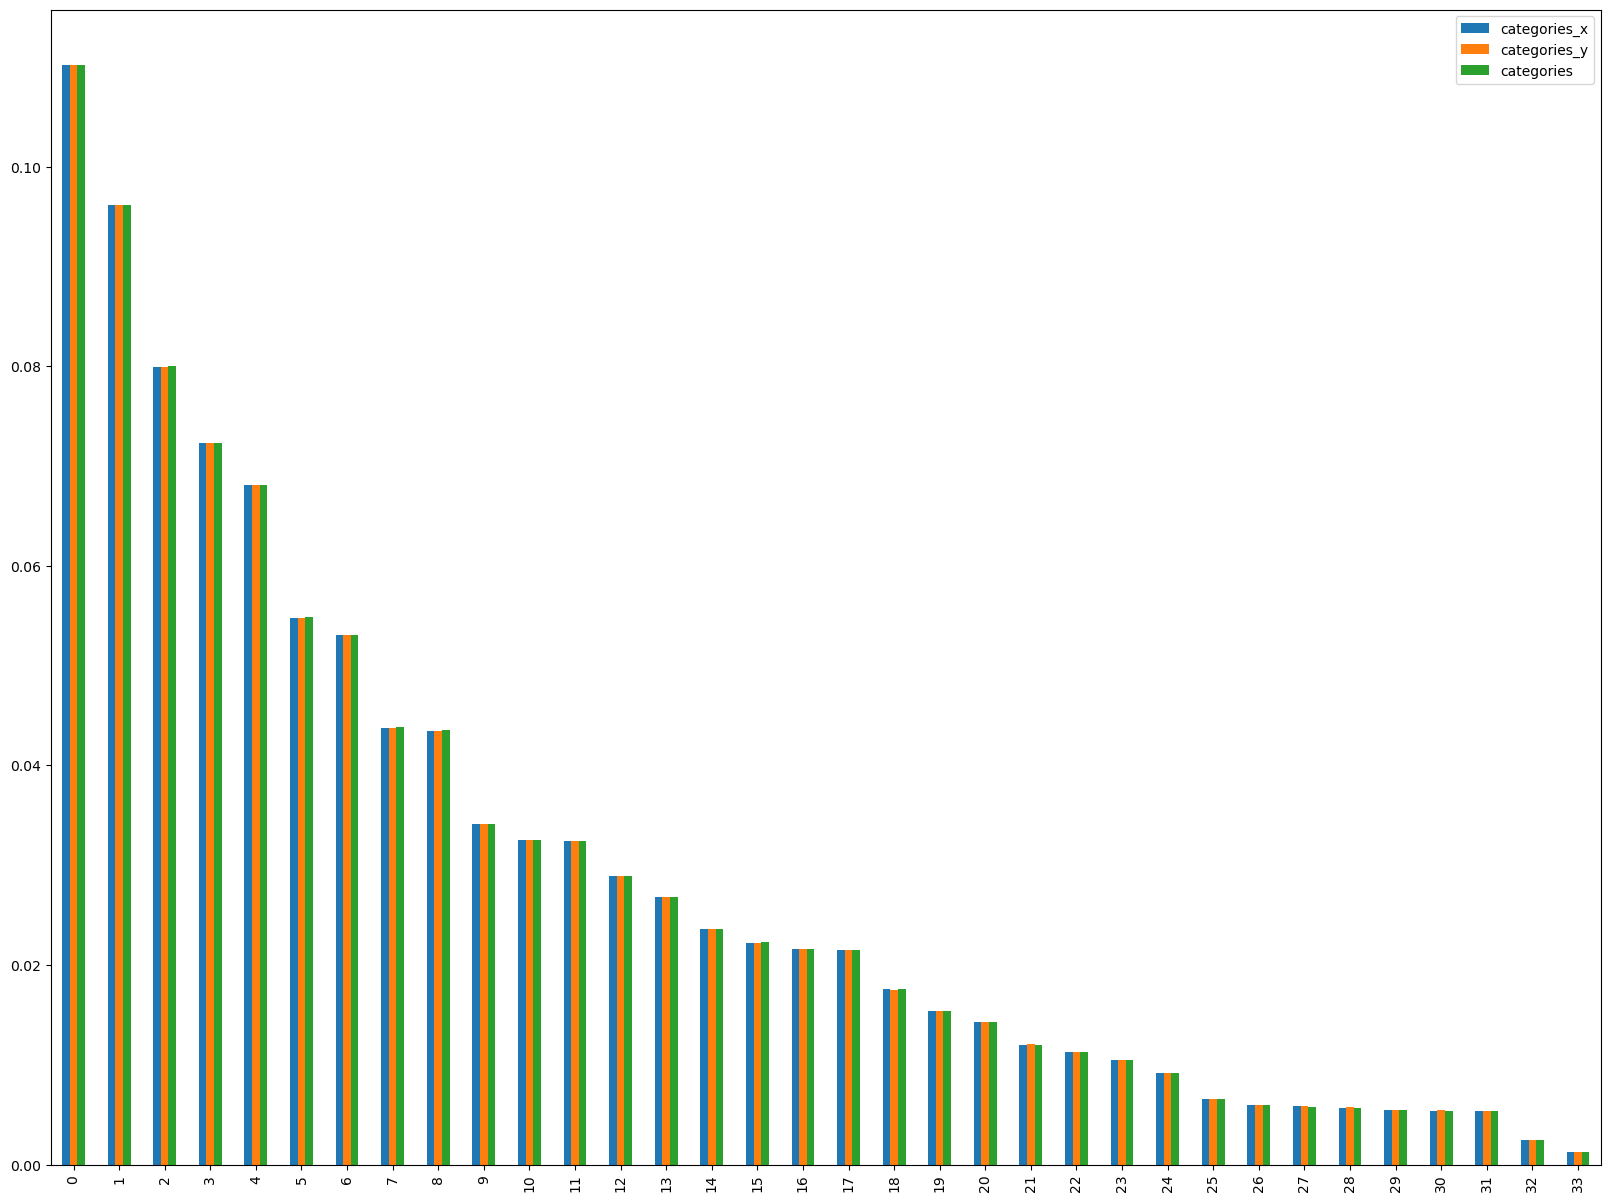

In [5]:
mark_distrib.plot(kind="bar", figsize=(20,15))

In [6]:
X_test.sample(5)

,text,categories,embedding (Bert+MP),embedding (Bert+MP+class-arx),embedding (Bert+MP+class-zbm),embedding (Mathbert+CLS),embedding (Mathbert+MP+class-arx),embedding (Mathbert+MP+class-zbm),embedding (Bert+TSDAE+MP),embedding (Bert+TSDAE+MP+class-arx),...,embedding (SBert+ret_class-arx),embedding (SBert+ret_class-zbm),embedding (Specter 2+MP),embedding (Specter 2.0+MP+class-arx),embedding (Specter 2.0+MP+class-zbm),embedding (Specter 2+MP+class-zbm+anch-arx),embedding (Specter 2+MP+anch-arx+class-arx+class-zbm),embedding (SGPT),embedding (SGPT+class-zbm),embedding (SGPT+class-arx)
12671,How to generalize known results on equations o...,math.GR,"[-0.5948714, 0.033822946, 0.16509426, -0.20818...","[-0.31627396, -0.3908026, -0.08605332, -0.1108...","[-0.88128906, 1.8731099, -0.12536958, -0.68975...","[-0.0058395388, 0.046763662, 0.022565566, 0.01...","[0.19404751, 0.036209904, -0.41869897, -0.8676...","[-0.26513693, 0.34376696, -0.022568047, -0.386...","[-0.3878198, 0.12612209, 0.16596618, -0.044989...","[-0.3334206, -0.8842272, 0.33304113, -0.354686...",...,"[0.058628563, 0.005235901, -0.0020427937, 0.03...","[0.026541252, -0.019629192, -0.03258359, -0.05...","[0.43531373, 0.67408174, -0.106960215, 0.16571...","[0.8134239, 1.0893846, 2.4253008, -0.060614206...","[0.46206376, 0.067426294, -0.99459916, 1.06978...","[0.14588831, 0.22826433, 0.07254162, -0.416497...","[0.8843392, 1.278731, 1.2384918, -0.05088813, ...","[-0.76357776, -1.2245779, -0.3090015, -1.34108...","[-0.2308117, 0.13849342, 0.36060303, 0.1644953...","[0.48135272, -0.48880422, 0.22366586, 2.234792..."
7031,Walks on hyperplane arrangements and optimizat...,math.OC,"[-0.65221983, -0.05825556, 0.23257056, -0.1024...","[-0.49226755, 0.47254744, -0.008840516, 0.0436...","[-0.6371607, 0.098518655, 0.5674271, 0.092872,...","[-0.0092273615, 0.039765663, 0.026695035, -0.0...","[-0.77787983, -0.13251066, -0.44922343, -0.100...","[0.70615536, -0.76723737, -0.30874982, -0.7335...","[-0.31530875, -0.062314045, 0.3414706, 0.12877...","[-0.25001827, -0.69984627, -0.26943064, 0.4597...",...,"[0.010126873, -0.066046454, -0.0021296425, 0.0...","[0.0077830325, -0.043246582, -0.00652468, -0.0...","[0.17572832, 0.3406484, 0.0013948664, -0.13721...","[0.6329104, 1.1312339, 0.2708295, 1.9870447, -...","[-0.056744073, -0.87305766, 0.17083539, 0.7615...","[0.031170288, -1.3259081, -0.25808096, -0.7676...","[-0.3682405, -0.14171642, -0.43074688, 1.62243...","[0.8162981, 1.6502532, 1.086777, -1.2625293, -...","[0.37206167, -0.42986786, 0.5310229, -0.075224...","[0.8784575, -1.0297122, -0.42274436, 0.331002,..."
21519,Multilinear smoothing and local well-posedness...,math.AP,"[-0.31388322, 0.08077307, 0.5904392, -0.271053...","[-0.040032636, -0.38302377, -0.66541463, -0.08...","[-0.7040993, -0.13618192, -0.18149196, 0.06067...","[-0.034132075, 0.04899107, 0.06252548, 0.00949...","[0.13965043, 0.41331849, 1.093485, 1.3403717, ...","[-0.4937484, 1.1357663, 0.29295403, 0.25225687...","[-0.08168597, -0.13384537, 0.40199926, -0.0810...","[0.25533375, -0.5756481, -0.23512204, -0.07481...",...,"[0.024923906, -0.024897905, 0.023775965, 0.037...","[-0.0032504036, 0.039399736, 0.023120556, 0.00...","[0.5400846, 0.5615073, 0.3141768, 0.37823403, ...","[0.18385854, -0.5537137, -0.6416115, 0.2928775...","[-0.56078523, -1.6497179, 0.837324, 1.0191606,...","[-2.5603385, -0.2535614, 1.1548451, 0.86572963...","[-1.6013882, -0.23946325, 0.03141989, 0.896924...","[-1.5673476, -0.70715934, 0.03178444, -0.39708...","[0.068566464, -0.33350256, 0.6756381, -0.07707...","[0.1604757, 0.24631672, -1.5027282, 0.67866254..."
24256,The Dolgopyat inequality in \BV\ for non-Marko...,math.DS,"[0.06562808, -0.18195006, 0.7539021, -0.298845...","[-0.76086825, -0.67538244, 1.5053674, 0.397216...","[0.045810685, 0.6499113, -0.14541496, -0.46643...","[-0.035678405, 0.020779854, 0.008437258, -0.02...","[0.3230399, -0.07611236, -0.08961628, -0.63267...","[-0.21239223, -0.49919683, -0.3160234, -0.8296...","[0.31461975, -0.24257325

In [7]:
# Prerequisites for the models
bert_base = models.Transformer('bert-base-uncased')
bert_mp = SentenceTransformer(modules=[bert_base, models.Pooling(bert_base.get_word_embedding_dimension())])

mathbert_base = models.Transformer('witiko/mathberta')
mathbert_mp = SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension())])
mathbert_cls = SentenceTransformer(modules=[mathbert_base, models.Pooling(mathbert_base.get_word_embedding_dimension(), pooling_mode="cls")])

bert_mlm_base = models.Transformer("./bert+re-train_mlm_abstracts_arxiv")
bert_mlm_mp = SentenceTransformer(modules=[bert_mlm_base, models.Pooling(bert_mlm_base.get_word_embedding_dimension())])

sbert = SentenceTransformer('all-mpnet-base-v2')
# alternative: sbert = SentenceTransformer('all-distilroberta-v1')

specter2_base = models.Transformer('allenai/specter2_base')

# Definition of models that are evaluated
# combine models into dict
eval_models = {
    "Bert+MP": bert_mp,
    "Bert+MP+class-arx": SentenceTransformer('./bert+mean-pooling+retrain_class_arxiv'),
    "Bert+MP+class-zbm": SentenceTransformer('./bert+mean-pooling+retrain_class_zbmath'),
    
    "Mathbert+CLS": mathbert_cls,
    "Mathbert+MP+class-arx": SentenceTransformer('./mathbert+mean-pooling+retrain_class_arxiv'),
    "Mathbert+MP+class-zbm": SentenceTransformer('./mathbert+mean-pooling+retrain_class_zbmath'),
    
    "Bert+TSDAE+MP": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv'),
    "Bert+TSDAE+MP+class-arx": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_arxiv'),
    "Bert+TSDAE+MP+class-zbm": SentenceTransformer('./bert+mean-pooling+re-train_tsdae_abstracts_arxiv+retrain_class_zbmath'),
    
    "Bert+MLM+MP": bert_mlm_mp,
    "Bert+MLM+MP+class-arx": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv'),
    "Bert+MLM+MP+class-zbm": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath'),
    "Bert+MLM+MP+class-zbm+anch-arx": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_zbmath_anchor_arxiv'),
    "Bert+MLM+MP+class-arx+anch-arx+class-zbm": SentenceTransformer('./bert+re-train_mlm_abstracts_arxiv+mean-pooling+retrain_class_arxiv_anchor_arxiv_class_zbmath'),
    
    "SBert": sbert,
    "SBert+ret_class-arx": SentenceTransformer('./sbert+retrain_class_arxiv'),
    "SBert+ret_class-zbm": SentenceTransformer('./sbert+retrain_class_zbmath'),
    
    "Specter 2+MP": SentenceTransformer(modules=[specter2_base, models.Pooling(specter2_base.get_word_embedding_dimension())]),
    "Specter 2.0+MP+class-arx": SentenceTransformer('./specter2+mp+retrain_class_arxiv'),
    "Specter 2.0+MP+class-zbm": SentenceTransformer('./specter2+mp+retrain_class_zbmath'),
    "Specter 2+MP+class-zbm+anch-arx": SentenceTransformer('./specter2+mp+retrain_class_zbmath_anchor_arxiv'),
    "Specter 2+MP+anch-arx+class-arx+class-zbm": SentenceTransformer('./specter2+mp+retrain_anchor_arxiv_class_arxiv_class_zbmath'),
    
    "SGPT": SentenceTransformer('Muennighoff/SGPT-125M-weightedmean-nli-bitfit'),
    "SGPT+class-arx": SentenceTransformer('./gpt+retrain_class_arxiv'),
    "SGPT+class-zbm": SentenceTransformer('./gpt+retrain_class_zbmath'),
}

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at witiko/mathberta were not used when initializing RobertaModel: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.laye

In [8]:
def suggest(eval_models, corpus, queries, device="cuda:0", msc_col="MSC", **search_args):
    msc_sug = pd.DataFrame()
    with tqdm(total=len(eval_models), desc="Models") as pb:
        for n,m in eval_models.items():
            c = torch.stack([torch.tensor(v) for v in corpus["{} ({})".format("embedding", n)].values])
            c.to(device)
            c = stu.normalize_embeddings(c)
            
            q = torch.stack([torch.tensor(v) for v in queries["{} ({})".format("embedding", n)].values])
            q.to(device)
            q = stu.normalize_embeddings(q)
            
            idxs = pd.Series([[r["corpus_id"] for r in res] for res in stu.semantic_search(q, c, score_function=stu.dot_score, **search_args)])
            msc_sug["{} ({})".format(msc_col, n)] = idxs.map(lambda e: corpus.loc[e][msc_col].values)

            pb.update()
    msc_sug.index = queries.index
    return msc_sug

In [ ]:
%%time
X_test = X_test.join(suggest(eval_models, X_train, X_test, device="cuda:0", msc_col="categories", top_k=200, query_chunk_size=5000, corpus_chunk_size=500000))
X_test.to_pickle("arxiv-200-recommendations-single-class-multi-test.pkl")

Models:   0%|          | 0/25 [00:00<?, ?it/s]

In [ ]:
%%time
X_eval = X_eval.join(suggest(eval_models, X_train, X_eval, device="cuda:0", msc_col="categories", top_k=200, query_chunk_size=5000, corpus_chunk_size=500000))
X_eval.to_pickle("arxiv-200-recommendations-single-class-multi-eval.pkl")